In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Initialization

In [ ]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [ ]:
train_path = "/content/drive/MyDrive/Models/FeatherFind/train_data.json"
val_path = "/content/drive/MyDrive/Models/FeatherFind/val_data.json"
test_path = "/content/drive/MyDrive/Models/FeatherFind/test_data.json"

In [ ]:
EPOCHS = 100
BATCH_SIZE = 32

In [ ]:
def load_data(dataset_path):
  with open(dataset_path) as fp:
    data = json.load(fp)

    # convert lists into numpy array
    inputs = np.array(data['mfcc'])
    targets = np.array(data['labels'])

    return inputs, targets

In [ ]:
def prepare_datasets(data_path):
  X, y = load_data(data_path)
  X = X[..., np.newaxis]

  return X, y

In [ ]:
def create_model(input_shape):
    model = Sequential()

    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=input_shape))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same'))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same'))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=256, kernel_size=(2,2), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same'))
    model.add(BatchNormalization())

    model.add(Flatten())

    model.add(Dense(units=256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.5))

    model.add(Dense(units=128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.5))

    model.add(Dense(units=41, activation='softmax'))

    return model

In [ ]:
def predict(model, X):
  X = X[np.newaxis, ...]

  y_pred = model.predict(X, verbose=0)
  y_pred = np.argmax(y_pred, axis=1)

  return y_pred[0]

In [ ]:
X_train, y_train = prepare_datasets(train_path)
X_val, y_val = prepare_datasets(val_path)
X_test, y_test = prepare_datasets(test_path)

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = create_model(input_shape)
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 429, 11, 64)         │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 215, 6, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 215, 6, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 213, 4, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 107, 2, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 107, 2, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 106, 1, 256)         │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 53, 1, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 53, 1, 256)          │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 13568)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │       3,473,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 41)                  │           5,289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,719,465 (14.19 MB)

 Trainable params: 3,718,569 (14.19 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0.001,
                              patience=5,
                              restore_best_weights=True,
                              verbose=True)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_accuracy',
                                        patience=3,
                                        factor=0.5,
                                        verbose=True)

checkpoint = ModelCheckpoint('best_weights.keras', save_best_only=True, monitor='val_accuracy', mode='max')


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[checkpoint, early_stopping, reduce_learning_rate], verbose=1)

Epoch 1/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 24s 94ms/step - accuracy: 0.0817 - loss: 5.1061 - val_accuracy: 0.3633 - val_loss: 3.4049 - learning_rate: 1.0000e-04
Epoch 2/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.2485 - loss: 3.7611 - val_accuracy: 0.4682 - val_loss: 2.8276 - learning_rate: 1.0000e-04
Epoch 3/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.3269 - loss: 3.2344 - val_accuracy: 0.5112 - val_loss: 2.5190 - learning_rate: 1.0000e-04
Epoch 4/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.3826 - loss: 2.9970 - val_accuracy: 0.5581 - val_loss: 2.3163 - learning_rate: 1.0000e-04
Epoch 5/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4515 - loss: 2.6894 - val_accuracy: 0.5787 - val_loss: 2.2211 - learning_rate: 1.0000e-04
Epoch 6/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4748 - loss: 2.5683 - val_accuracy: 0.6348 - val_loss: 2.1283 - learning_rate: 1.0000e-04
Epoch 7/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/st

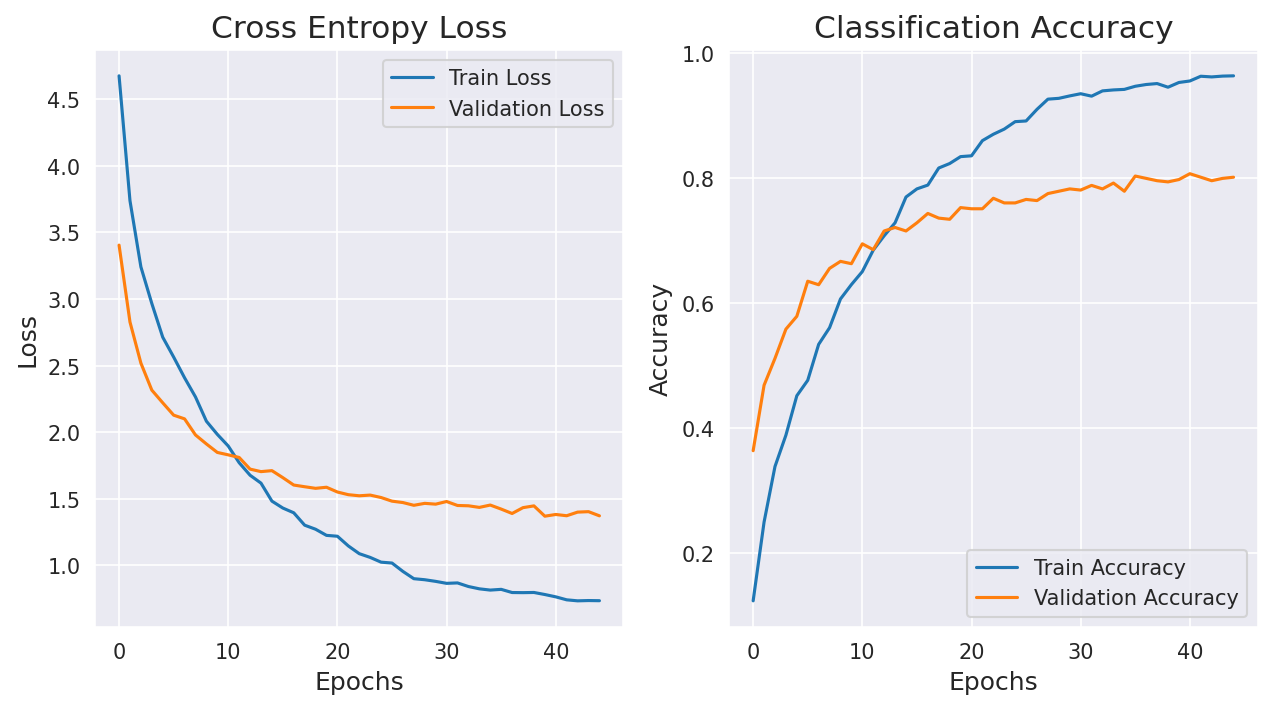

In [ ]:
metrics = pd.DataFrame(model.history.history)

plt.figure(figsize=(10, 5), dpi=150)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(metrics['loss'], label='Train Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.legend()

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(metrics['accuracy'], label='Train Accuracy')
plt.plot(metrics['val_accuracy'], label='Validation Accuracy')
plt.legend()

plt.show()

In [ ]:
# Evaluate test dataset
loss, acc = model.evaluate(X_test, y_test, verbose=False)

print('The accuracy of the model for testing data is:', acc*100)
print('The Loss of the model for testing data is:', loss)

The accuracy of the model for testing data is: 79.93197441101074
The Loss of the model for testing data is: 1.4968509674072266


In [ ]:
# Predict class probabilities
predicted_probs = model.predict(X_test, verbose=False)

# Convert probabilities to class labels
predicted_class = np.argmax(predicted_probs, axis=1)

# Get actual class labels
actual_class = np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test

# Find indices of correct and incorrect predictions
correct = np.nonzero(predicted_class == actual_class)[0]
incorrect = np.nonzero(predicted_class != actual_class)[0]

# Print results
print("Correct predicted classes:", correct.shape[0])
print("Incorrect predicted classes:", incorrect.shape[0])

Correct predicted classes: 470
Incorrect predicted classes: 118


In [ ]:
def get_categories(data_path):
  with open(data_path, "r") as fp:
    data = json.load(fp)

  mapping = data['mapping']
  categories = {i: category for i, category in enumerate(mapping)}

  return categories
categories = get_categories(test_path)
print(categories)


{0: 'White-throated Bushchat', 1: 'Long-tailed Duck', 2: 'Swamp Francolin', 3: 'Jerdon_s Babbler', 4: 'Grey-sided Thrush', 5: 'Egyptian Vulture', 6: 'Grey-crowned Prinia', 7: 'Black Kite', 8: 'Slender-billed Babbler', 9: 'Spotted Dove', 10: 'Himalayan Monal', 11: 'Large-billed Crow', 12: 'Grey Treepie', 13: 'Red-billed Blue Magpie', 14: 'Cheer Pheasant', 15: 'Spiny Babbler', 16: 'House Sparrow', 17: 'Great Slaty Woodpecker', 18: 'Common Cuckoo', 19: 'Rufous-necked Hornbill', 20: 'Wood Snipe', 21: 'Pallas_s Fish Eagle', 22: 'Bristled Grassbird', 23: 'Common Wood Pigeon', 24: 'House Crow', 25: 'Rufous Treepie', 26: 'Asian Koel', 27: 'Black-necked crane', 28: 'Indian Spotted Eagle', 29: 'Sarus Crane', 30: 'Greater Spotted Eagle', 31: 'Rustic Bunting', 32: 'Eastern Imperial Eagle', 33: 'Rose-ringed Parakeet', 34: 'Black-breasted Parrotbill', 35: 'Steppe Eagle', 36: 'Kashmir Flycatcher', 37: 'Common Pochard', 38: 'Swamp Grass-babbler', 39: 'Saker Falcon', 40: 'Satyr Tragopan'}


In [ ]:
labels = np.arange(len(categories))

print(classification_report(actual_class, predicted_class,
                            target_names=[categories[i] for i in labels],
                            labels=labels))


                           precision    recall  f1-score   support

  White-throated Bushchat       0.00      0.00      0.00         1
         Long-tailed Duck       0.73      0.80      0.76        20
          Swamp Francolin       0.00      0.00      0.00         3
         Jerdon_s Babbler       1.00      0.67      0.80         3
        Grey-sided Thrush       0.00      0.00      0.00         4
         Egyptian Vulture       0.00      0.00      0.00         2
      Grey-crowned Prinia       1.00      0.50      0.67         2
               Black Kite       0.69      0.83      0.76        30
   Slender-billed Babbler       1.00      0.75      0.86         4
             Spotted Dove       0.86      0.73      0.79        33
          Himalayan Monal       0.86      0.67      0.75         9
        Large-billed Crow       0.94      0.97      0.95        32
             Grey Treepie       0.79      0.74      0.77        31
   Red-billed Blue Magpie       0.76      0.80      0.78     

In [ ]:
con_matrix = tf.math.confusion_matrix(
        labels=actual_class,
        predictions=predicted_class,
        num_classes=41)

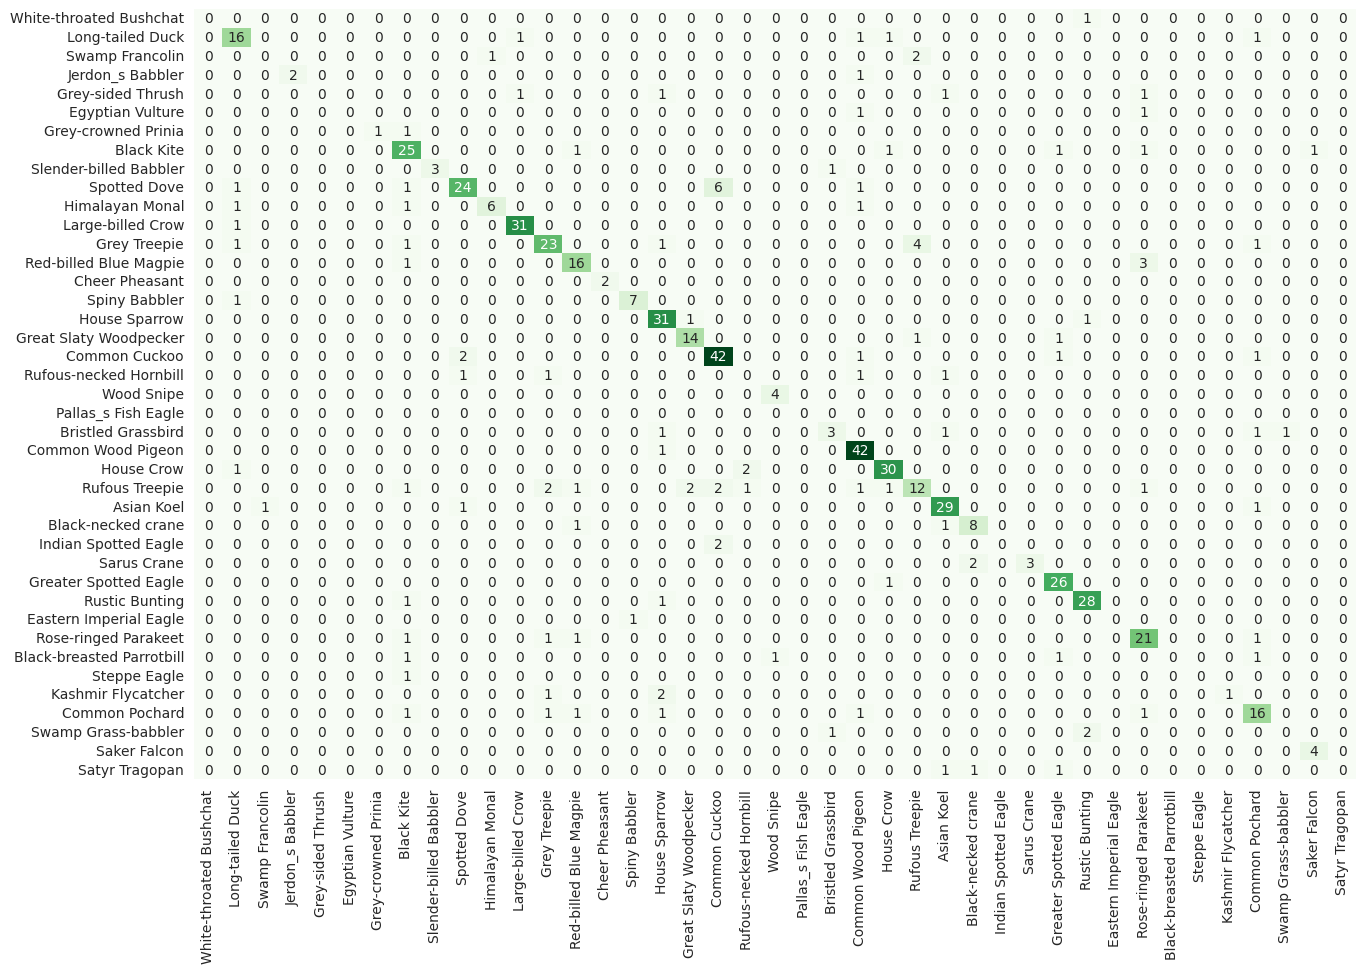

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(con_matrix, annot=True, fmt='g', cbar=False, xticklabels=categories.values(), yticklabels=categories.values(), cmap="Greens")
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Models/FeatherFind/cnn_model.keras')